# Prototype 01
#### Tasks
##### Done

- Why are we not using softmax in the last layer of the agent? [o]
- Check timos epsilon decay strategy [✓]
- Introduce verbosity levels [✓]
- Split the dataset presented to each client [✓]
- Check the format of training data [✓]
- Add softmax to the last layer [✓] 
- Make function to save the most important details about an experiment in a README.md file and save it with the models and the graphics [✓]
- Improve the log experiment function [✓]
- Check why the learning curve shows twice as many epochs as actually existent [✓]
- Add saving functionality to the plotting functions [✓]
- write the experiment summary directly into the md file [✓]
- Add the global training time and the round training time [✓]
- Add a name function to the agent and make the global agent return the correct name [✓]
- Check why there is twice as many episodes in the graph as there should be [✓]
- Align the markdown table to the left [✓]
- Save the full training time [✓]
- Save the rount training time on each client [✓]
- Add the execution date to the experiment report [✓]
- Use the pipe table [✓]
- How many threads can my macbook pro run in parallel => 6 (12 with Hyperthreadding) [✓]
- Check if the experiment directory already exists and if yest delete it and make space for the new files [✓]
- Check different types of tables [✓]
- Remove the verbosity flag from the server train functions [✓]
- Change the blue in the graphics to a darker blue and the red to a more poppy color. [✓]

##### Open

- Validate the copying of the parameters works properly
- How often do i have to initialze the replay memory?
- Make sure that the weights of the DQN are not being reset by the training
- If you really want to make this work online then the right aggregation strategy is key. Maybe ensemble models would be good.
- Check different federated aggregation strategies for class distinct problems
- Parallelize the training
- Move the training to the GPU.
- Make the threadding more efficient
- Add f1 score and confusion matrix
- Check the weighting strategy that Timo used
- Ipmlemtne Multiclass Imbalance Degree (MID) Metric
- Print a graph with overall attack detection accuracy (How many got mitigated and how many did not get mitigated)
- Check which loss we are using (purpose of binary cross entropy loss)
- Add confusion matrices
- Check RMS Prop
- Check why there is 4 actions (possible outputs) of the DQN while we only use 3 MTDs. Does zero mean no MTD?
- Move each class to its own file
- Better split the training data to clients
- What is the purpose of share memory function?
- Check if the DQN is always randomly re-initialized
- plot the training data splits
- Check why the parallelized training is not faster?
- Maybe we should use the model with the best test performance
- Check why there is 4 output actions
- Check the format of the training data
- Make some graphs over the test accuracies for all clients over the rounds
- Make graphs that cover the global test accuracy over all rounds for all clients (including the global agent)
- Check that the test data is independant from the train data
- Check if the replay memoery init can be moved internally (client_01.init_replay_memory(MIN_REPLAY_SIZE))

### Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

### Training on Local Machine

In [1]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01


In [2]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [3]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [4]:
# Validate that python 3.10 is used
!python --version

Python 3.10.9


In [5]:
def seed_random():
    random.seed(42)
    torch.random.manual_seed(42)
    np.random.seed(42)

### 1. Dependencies

In [5]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [6]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.data_provider import DataProvider
#from src.agent import Agent
#from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent_on_afterstates

### 2. Hyperparameters

In [7]:
# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4
LOG_FREQ = 100
DIMS = 20
PI = 3

### 3. Source

In [8]:
def split_training_data(training_data, n_strides):
    strides = []
    for i in range(n_strides):
        strides.append(dict())

    for key, value in training_data.items():
        #print(f"{key} => {len(value)}")
        array_split = np.array_split(value, n_strides)
        for i in range(n_strides):
            strides[i][key] = array_split[i]
        
    return strides

In [9]:
from typing import Dict, Tuple, List
from src.custom_types import Behavior, MTDTechnique, actions, supervisor_map
import numpy as np
import random


# handles the supervised, online-simulation of episodes
class SensorEnvironment:

    def __init__(self, train_data: Dict[Behavior, np.ndarray] = None):
        #print("Recognized Behaviours")
        #print(train_data.keys())
        self.train_data = train_data
        self.current_state: np.array = None
        self.observation_space_size: int = len(self.train_data[Behavior.NORMAL][0][:-1])
        self.actions: List[int] = [i for i in range(len(actions))]

    # Returns a randomly selected attack state with non normal behaviour.
    def sample_random_attack_state(self):
        """i.e. for starting state of an episode,
        (with replacement; it is possible that the same sample is chosen multiple times)"""
        rb = random.choice([b for b in self.train_data.keys() if b != Behavior.NORMAL])
        attack_data = self.train_data[rb]
        return attack_data[np.random.randint(attack_data.shape[0], size=1), :]

    # Return random sample with specified behaviour
    def sample_behavior(self, b: Behavior):
        behavior_data = self.train_data[b]
        return behavior_data[np.random.randint(behavior_data.shape[0], size=1), :]

    def step(self, action: int):
        current_behavior = self.current_state.squeeze()[-1]

        if current_behavior in supervisor_map[action]:
            # print("correct mtd chosen according to supervisor")
            new_state = self.sample_behavior(Behavior.NORMAL)
            reward = self.calculate_reward(True)
            isTerminalState = True
        else:
            # print("incorrect mtd chosen according to supervisor")
            new_state = self.sample_behavior(current_behavior)
            reward = self.calculate_reward(False)
            isTerminalState = False

        self.current_state = new_state
        return new_state, reward, isTerminalState

    def reset(self):
        self.current_state = self.sample_random_attack_state()
        return self.current_state

    # TODO: possibly adapt to distinguish between MTDs that are particularly wasteful in case of wrong deployment
    def calculate_reward(self, success):
        """
        this method can be refined to distinguish particularly wasteful MTDs (i.e. Dirtrap penalized harder than rootkit sanitization)
        """
        if success:
            return 1
        else:
            return -1

In [10]:
from typing import Dict
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        # Layers
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        #self.softmax = torch.nn.Softmax()
        # Why are we not using softmax in the last layer

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

In [11]:
from typing import Dict
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random

class Agent:
    def __init__(self, agent_id: int, input_dims: int, n_actions, batch_size,
                 lr, gamma, epsilon, eps_end=0.02, eps_dec=1e-4, buffer_size=100000, is_global_agent=False, verbose=False):
        self.agent_id = agent_id
        self.is_global_agent = is_global_agent
        self.verbose = verbose
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_max = epsilon # Initial epsilon value
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.input_dims = input_dims
        self.n_actions = n_actions

        self.episode_action_memory = set()
        self.replay_buffer = deque(maxlen=buffer_size)
        self.reward_buffer = deque([0.0], maxlen=100)  # for printing progress

        self.batch_size = batch_size

        self.online_net = DeepQNetwork(lr, n_actions=n_actions,
                                       input_dims=input_dims,
                                       fc1_dims=60, fc2_dims=30)
        self.target_net = DeepQNetwork(lr, n_actions=n_actions,
                                       input_dims=input_dims,
                                       fc1_dims=60, fc2_dims=30)
        self.target_net.load_state_dict(self.online_net.state_dict())

    def choose_action(self, observation):
        try:
            if np.random.random() > self.epsilon:
                #
                action = self.take_greedy_action(observation)
                if action in self.episode_action_memory:
                    action = np.random.choice(list(set(self.action_space).difference(self.episode_action_memory)))
            else:
                action = np.random.choice(list(set(self.action_space).difference(self.episode_action_memory)))
            self.episode_action_memory.add(action)
        except ValueError:
            return -1
        return action

    def take_greedy_action(self, observation):
        state = torch.from_numpy(observation.astype(np.float32)).to(self.online_net.device)
        actions = self.online_net.forward(state)
        action = torch.argmax(actions).item()
        return action

    def learn(self):
        # init data batch from memory replay for dqn
        transitions = random.sample(self.replay_buffer, self.batch_size)
        b_obses = np.stack([t[0].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_actions = np.asarray([t[1] for t in transitions]).astype(np.int64)
        b_rewards = np.asarray([t[2] for t in transitions]).astype(np.int16)
        b_new_obses = np.stack([t[3].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_dones = np.asarray([t[4] for t in transitions]).astype(np.int16)
        t_obses = torch.from_numpy(b_obses).to(self.target_net.device)
        t_actions = torch.from_numpy(b_actions).to(self.target_net.device)
        t_rewards = torch.from_numpy(b_rewards).to(self.target_net.device)
        t_new_obses = torch.as_tensor(b_new_obses).to(self.target_net.device)
        t_dones = torch.as_tensor(b_dones).to(self.target_net.device)

        # compute targets
        target_q_values = self.target_net(t_new_obses)
        max_target_q_values = torch.max(target_q_values, dim=1)[0]

        targets = (t_rewards + self.gamma * (1 - t_dones) * max_target_q_values).unsqueeze(1)

        # compute loss
        q_values = self.online_net(t_obses)
        taken_action_q_values = torch.gather(input=q_values, dim=1, index=t_actions.unsqueeze(1))

        loss = self.online_net.loss(taken_action_q_values, targets).to(self.target_net.device)

        # gradient descent
        self.online_net.optimizer.zero_grad()
        loss.backward()
        self.online_net.optimizer.step()

        # epsilon decay
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def get_weights(self):
        if self.verbose:
            print(f"SERVER <--- WEIGHTS --- {self.get_name()}")
        return copy.deepcopy(self.target_net.state_dict())
    
    def update_weights(self, model_params):
        #if self.verbose:
        #    print(f"SERVER --- WEIGHTS ---> {self.get_name()}")
        self.online_net.load_state_dict(copy.deepcopy(model_params))
        self.target_net.load_state_dict(copy.deepcopy(model_params))
        
    def get_name(self):
        if self.agent_id == 0:
            return "Global Agent"
        else:
            return f"Agent {self.agent_id}"
    
    
    def save_agent_state(self, n: int, directory: str):
        torch.save({
            'online_net_state_dict': self.online_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'batch_size': self.batch_size,
            'replay_buffer': self.replay_buffer,
            'reward_buffer': self.reward_buffer,
            'action_space': self.action_space,
            'gamma': self.gamma,
            'eps': self.epsilon,
            'eps_min': self.eps_min,
            'eps_dec': self.eps_dec,
            'lr': self.lr
        }, f"{directory}/trained_models/agent_{n}.pth")

        #torch.save(self.online_net.state_dict(), f"offline_prototype_2_raw_behaviors/trained_models/online_net_{n}.pth")
        #torch.save(self.target_net.state_dict(), f"offline_prototype_2_raw_behaviors/trained_models/target_net_{n}.pth")

In [12]:
import torch
from torch import nn, optim
import copy
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline

class Client:
        # memory buffer is influenced by env.step -> resetting to previous action, which may result in unbalanced training
    def __init__(self, client_id: int, agent: Agent, environment: SensorEnvironment, save_path=""):
        self.client_id = client_id
        self.agent = agent
        self.environment = environment
        self.episode_returns = [] 
        self.eps_history = []
        self.save_path = save_path
        self.start_time = 0
        self.end_time = 0
    
    def init_replay_memory(self, min_size):
        obs = self.environment.reset()
        episode_action_memory = []
        i = 0
        while i < min_size:
            try:
                action = np.random.choice(list({0,1,2,3}.difference(episode_action_memory)))
                episode_action_memory.append(action)
            except ValueError:
                obs = self.environment.reset()
                episode_action_memory = []
                # results in slightly less entries than min_size
                print("exhausted all mtd techniques")
                continue
            i += 1

            new_obs, reward, done = self.environment.step(action)
            idx1 = -1 if obs[0, -1] in Behavior else -2
            idx2 = -1 if new_obs[0, -1] in Behavior else -2
            transition = (obs[:, :idx1], action, reward, new_obs[:, :idx2], done)
            self.agent.replay_buffer.append(transition)

            obs = new_obs
            if done:
                obs = self.environment.reset()
                episode_action_memory = []

                
    def train_agent(self, num_episodes, t_update_freq, verbose=False):
        self.start_time = time()
        step = 0
        for num_episode in range(num_episodes):
            episode_return = 0
            episode_steps = 0
            done = False
            obs = self.environment.reset()
            while not done:
                idx1 = -1 if obs[0, -1] in Behavior else -2
                action = self.agent.choose_action(obs[:, :idx1])
                if action == -1:
                    print("Agent exhausted all MTD techniques upon behavior: ", obs[0, -1])
                    self.agent.episode_action_memory = set()
                    done = True
                    continue

                new_obs, reward, done = self.environment.step(action)
                idx2 = -1 if new_obs[0, -1] in Behavior else -2
                episode_return += reward
                self.agent.replay_buffer.append((obs[:, :idx1], action, reward,
                                            new_obs[:, :idx2], done))
                self.agent.reward_buffer.append(reward)
                if done:
                    self.agent.episode_action_memory = set()

                self.agent.learn()
                obs = new_obs

                episode_steps += 1
                # update target network
                step += 1
                if step % t_update_freq == 0:
                    self.agent.update_target_network()

            self.episode_returns.append(episode_return / episode_steps)
            self.eps_history.append(self.agent.epsilon)
         
        self.end_time = time() 
        print(f"The total training time was {self.get_training_time()}s")
        
    
    def receive_weights(self, model_params):
        """ Receive aggregated parameters, update model """
        #self.agent.load_state_dict(copy.deepcopy(model_params))
        self.agent.update_weights(model_params)
        
    def get_weights(self):
        return self.agent.get_weights()
    
    def get_training_summary(self):
        return self.episode_returns, self.eps_history
    

    def plot_learning_curve(self, filename, nr_round: int):
        title = f"Learning Curve until Round {nr_round} on Client {self.client_id}"
        returns =  []
        epsilons = []
        returns, epsilons = self.get_training_summary()

        assert len(returns) == len(epsilons)
        x = [i + 1 for i in range(len(returns))]
        fig = plt.figure()

        ax = fig.add_subplot(111, label="1")
        ax2 = fig.add_subplot(111, label="2", frame_on=False)
        ax.set_title(title)

        color_1 = "red"
        ax.plot(x, epsilons, color=color_1)
        ax.set_xlabel("Episode", color='black')
        ax.set_ylabel("Epsilon", color=color_1)
        ax.set_ylim([0, 1])
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors=color_1)
        
        N = len(returns)
        running_avg = np.empty(N)
        for t in range(N):
            running_avg[t] = np.mean(returns[max(0, t - 20):(t + 1)])
        
        color_2 = "blue"
        ax2.scatter(x, running_avg, color=color_2, s=2 ** 2)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.yaxis.tick_right()
        ax2.set_ylabel('Average Return', color=color_2)
        ax2.set_ylim([0, 1])
        ax2.yaxis.set_label_position('right')
        ax2.tick_params(axis='y', colors=color_2)

        if self.save_path:
            if not os.path.isdir(self.save_path):
                os.makedirs(self.save_path)
            filepath = os.path.join(self.save_path, filename)
            plt.savefig(filepath)
            
        plt.show()
        
    def get_training_time(self):
        return self.end_time - self.start_time
    
    def plot_training_data_split(self):
        D = {}
        for key, value in self.environment.train_data.items():
            name = str(key).split('.')[1]
            D[name] = len(value)
        
        plt.bar(range(len(D)), list(D.values()), align='center', color='blue')
        plt.xticks(range(len(D)), list(D.keys()))
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Behavior Distribution on Client {self.client_id}")
        plt.ylabel('n_samples')
        
        filename = f"behavior_sample_distribution_on_client-{self.client_id:02d}.png"
        filepath = os.path.join(self.save_path, filename)
        plt.savefig(filepath, bbox_inches="tight")
        plt.show()

In [13]:
#NR_ROUNDS = 10
#NR_EPISODES_PER_ROUND = 1000
import torch
from torch import nn
import copy

from typing import List, Dict
import threading
import numpy as np
import json
from tabulate import tabulate
from datetime import date

class Server:
    def __init__(self, global_agent: Agent, test_data, experiment_id, save_path, nr_rounds = NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False):
        self.clients = []
        self.global_agent = global_agent
        self.test_data = test_data
        self.save_path = save_path
        self.experiment_id = experiment_id
        self.file_path = os.path.join(save_path, f"experiment-{experiment_id:02d}_summary.md")
        self.nr_rounds = nr_rounds
        self.nr_epochs_per_round = nr_episodes_per_round
        self.parallelized = parallelized
        
    def aggregate_weights(self):
        client_params = {client.client_id: client.get_weights() for client in self.clients}
        new_params = copy.deepcopy(next(iter(client_params.values())))  # names
        for name in new_params:
            new_params[name] = torch.zeros(new_params[name].shape)
        for client_id, params in client_params.items():
            client_weight = 1/len(self.clients)
            for name in new_params:
                new_params[name] += params[name] * client_weight  # averaging
        #set new parameters to global model
        self.global_agent.update_weights(new_params)
        return new_params
         
    def broadcast_weights(self):
        for client in self.clients:
            client.receive_weights(self.global_agent.get_weights())

    def add_client(self, client: Client):
        self.clients.append(client)
      
    def run_federation(self, verbosity=[], evaluation_frequency: int = 10):
        start_time = time()
        
        self.document("")
        self.document(f"# Prototype 1 (Experiment {self.experiment_id})")
        self.document("---")
        self.document("")
        self.document(f"Executed on {date.today().strftime('%d.%m.%Y')}")

        self.save_experiment_summary()
        for nr_round in range(1, self.nr_rounds+1):
            if nr_round % evaluation_frequency == 0:
                self.document("")
                self.document('<div style="page-break-after: always;"></div>')
                self.document("")
                self.document("---")
                self.document(f"### Training Round {nr_round}/{self.nr_rounds}")
                self.document("")

            print(f">>> SERVER TRAINING ROUND {nr_round}/{self.nr_rounds} <<<")
            for client in self.clients:
                client.receive_weights(self.global_agent.get_weights())
                
            if self.parallelized:
                # Parallel training
                threads = []
                for client in self.clients:
                    client.agent.online_net.share_memory()
                    t = threading.Thread(target=Client.train_agent, args=(client, self.nr_epochs_per_round, 100))
                    t.start()
                    threads.append(t)
                    for t in threads:
                        t.join()
            else:
                # Sequential training
                for client in self.clients:
                    client.train_agent(self.nr_epochs_per_round, 100)
            
            self.aggregate_weights()
            if nr_round % evaluation_frequency == 0:
                for client in self.clients:
                    self.document(f"- Training Round {nr_round} on Client {client.client_id} took {round(client.get_training_time(), 2)}s")
                
                if "learning_curve" in verbosity:
                    for client in self.clients:
                        filename = f"round-{self.prefix(nr_round)}_agent-{(client.client_id):02d}_learning-curve.png"
                        client.plot_learning_curve(filename, nr_round)
                        self.document(f"![graph]({filename})")
                   
                if "performance_evaluation" in verbosity:
                    for client in self.clients:  
                        self.performance_evaluation(client.agent, self.test_data)
 
                    self.performance_evaluation(self.global_agent, self.test_data)
                    
        end_time = time()
        total_training_time = end_time - start_time
        print(f"Total training time: {total_training_time}")
        self.document(f"\n ### Total training time: {round(total_training_time, 2)}s")
           
    def document(self, text):
        text = text.replace("_", "\_")
        if self.save_path:
            with open(self.file_path,'a') as f:
                # Add newline to text
                text += "  \n"
                f.write(text)   
                
    def document_block(self, text):
        text = text.replace("_", "\_")
        if self.save_path:
            with open(self.file_path,'a') as f:
                # Add newline to text
                text += "\n \n  \n \n"
                f.write(text)  
                            
                    
    def prefix(self, round: int): 
        prefix_length = len(str(self.nr_rounds))
        return f"{round:0{prefix_length}d}"

    def plot_learning_curves(self):
        for client in self.clients:
            episode_returns, eps_history = client.get_training_summary()
            plot_learning_curve(f"{client.client_id}", episode_returns, eps_history)
            
    def save_experiment_summary(self):
        experiment_summary = {}
        self.document("## Configuration")
        self.document("### Server")
        self.document(f"- nr_clients: {len(self.clients)}")
        self.document(f"- nr_rounds: {self.nr_rounds}")
        self.document(f"- nr_epochs_per_round: {self.nr_epochs_per_round}")
        self.document(f"- parallelized: {self.parallelized}")
        self.document("")
        
        for client in self.clients:
            self.document(f"### Client {client.client_id}")
            self.document(f"- gamma: {client.agent.gamma}")
            self.document(f"- learning_rate: {client.agent.lr}")
            self.document(f"- batch_size: {client.agent.batch_size}")
            self.document(f"- epsilon_max: {client.agent.eps_max}")
            self.document(f"- epsilon_min: {client.agent.eps_min}")
            self.document(f"- epsilon_decay: {client.agent.eps_dec}")
            self.document(f"- input_dims: {client.agent.input_dims}")
            self.document(f"- output_dims: {client.agent.n_actions}")
            self.document("")

            self.document(f"Training Data Split")
            for key, value in client.environment.train_data.items():
                self.document(f"- {len(value)} samples of {key}")
                
            client.plot_training_data_split()
            self.document(f"![](behavior_sample_distribution_on_client-{client.client_id:02d}.png)")
            
        self.document(f"### Global Agent") 
        self.document(f"- id: {self.global_agent.agent_id}")
        self.document(f"- batch_size: {self.global_agent.batch_size}")
        self.document(f"- epsilon: 0")
        self.document(f"- batch_size: {self.global_agent.input_dims}")
        self.document(f"- batch_size: {self.global_agent.n_actions}")

            
    def performance_evaluation(self, agent: Agent, test_data):
        # check predictions with learnt dqn
        agent.online_net.eval()
        res_dict = {}
        objective_dict = {}
        with torch.no_grad():
            for b, d in test_data.items():
                if b != Behavior.NORMAL:
                    cnt_corr = 0
                    cnt = 0
                    for state in d:
                        action = agent.take_greedy_action(state[:-1])
                        if b in supervisor_map[action]:
                            cnt_corr += 1
                        cnt += 1
                    res_dict[b] = (cnt_corr, cnt)

                for i in range(len(actions)):
                    if b in supervisor_map[i]:
                        objective_dict[b] = actions[i]
        labels = ("Behavior", "Accuracy", "Objective")
        results = []

        for b, t in res_dict.items():
            results.append((b.value, f'{(100 * t[0] / t[1]):.2f}%', objective_dict[b].value))

        self.document(f"\n\n{agent.get_name()}\n")
        self.document(tabulate(results, headers=labels, tablefmt="pipe"))

        print(agent.get_name())
        print(tabulate(results, headers=labels, tablefmt="pipe"))

In [14]:
import os
import shutil

class Experiment:
    def __init__(self, base_path):
        self.base_path = base_path
        
    def get_experiment_path(self, experiment_id):
        path = os.path.join(self.base_path, f"experiments/experiment_{experiment_id:02d}")
        print(path)
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            shutil.rmtree(path)          
            os.makedirs(path)
            
        return path

-----------
### 4. Experiments
#### 4.1 Experiment 01

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01/experiments/experiment_01
/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


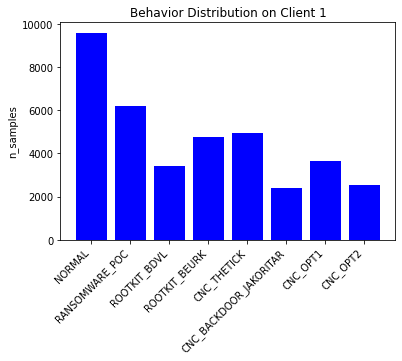

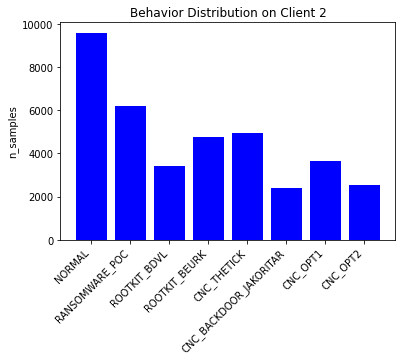

>>> SERVER TRAINING ROUND 1/10 <<<
The total training time was 8.192200899124146s
The total training time was 6.99475622177124s


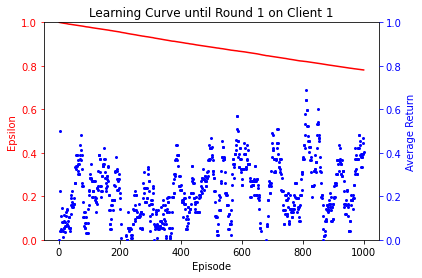

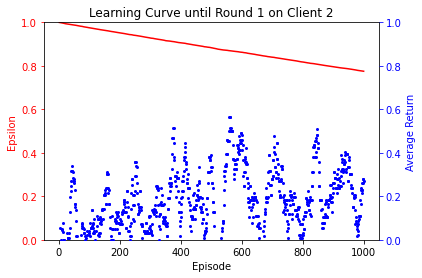

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.82%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 32.24%     | rootkit_sanitizer              |
| the_tick           | 86.94%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 72.07%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.56%     | cnc_ip_shuffle                 |
| data_leak_2        | 99.88%     | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 96.78%     | ransomware_file_extension_hide |
| bdvl               | 98.41%     | rootkit_sanitizer              |
| beurk              | 26.90%     | rootkit_sanitizer              |
| the_tick        

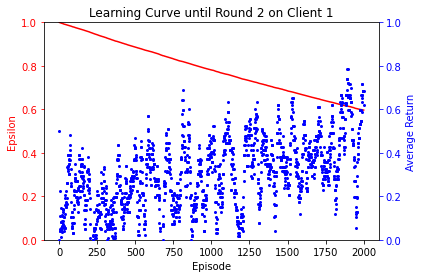

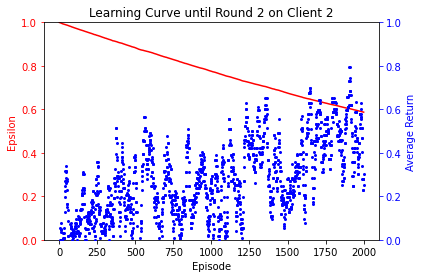

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.82%     | ransomware_file_extension_hide |
| bdvl               | 98.49%     | rootkit_sanitizer              |
| beurk              | 69.47%     | rootkit_sanitizer              |
| the_tick           | 92.49%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 40.14%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.65%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.71%     | ransomware_file_extension_hide |
| bdvl               | 98.32%     | rootkit_sanitizer              |
| beurk              | 59.48%     | rootkit_sanitizer              |
| the_tick        

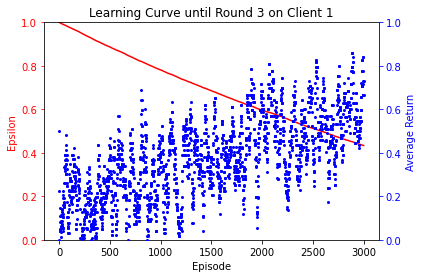

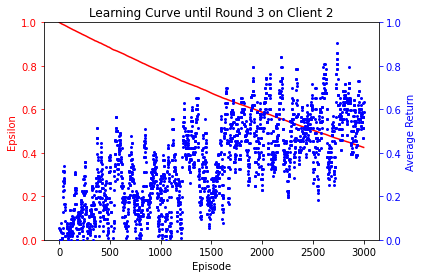

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 97.53%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 49.42%     | rootkit_sanitizer              |
| the_tick           | 96.28%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 69.84%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.29%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.34%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 44.28%     | rootkit_sanitizer              |
| the_tick        

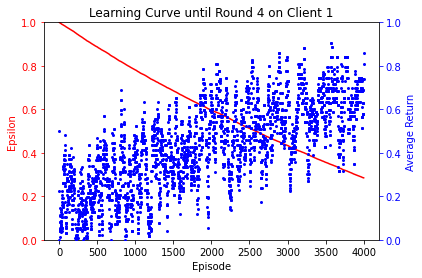

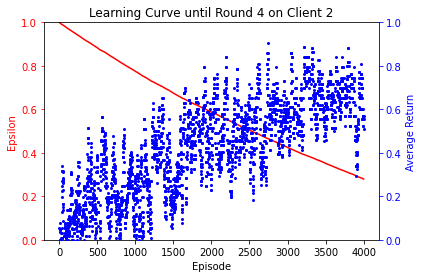

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.55%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 56.61%     | rootkit_sanitizer              |
| the_tick           | 97.65%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 67.61%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.56%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.82%     | ransomware_file_extension_hide |
| bdvl               | 98.94%     | rootkit_sanitizer              |
| beurk              | 73.10%     | rootkit_sanitizer              |
| the_tick        

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_path = experiments.get_experiment_path(experiment_id)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path)
client_02 = Client(2, agent_02, environment_02, experiment_path)
# initialize memory replay buffer (randomly)
client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

-----------
#### 4.2 Experiment 02

In [ ]:
experiment_id = 2
experiment_path = experiments.get_experiment_path(experiment_id)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, 2)

environment_01 = SensorEnvironment(training_data_strides[0])
environment_02 = SensorEnvironment(training_data_strides[1])

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=True)

client_01 = Client(1, agent_01, environment_01)
client_02 = Client(2, agent_02, environment_02)

client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

-----------
#### 4.3 Experiment 03

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01/experiments/experiment_03
/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
>>> SERVER TRAINING ROUND 1/10 <<<


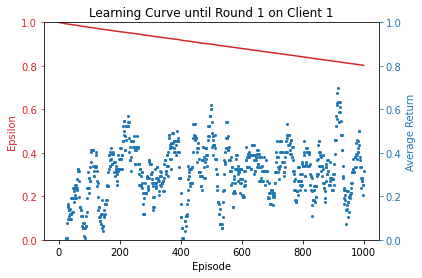

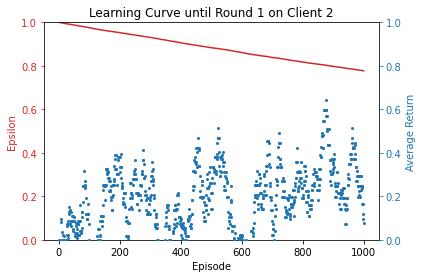

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.23%     | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

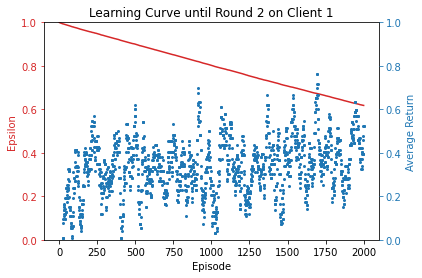

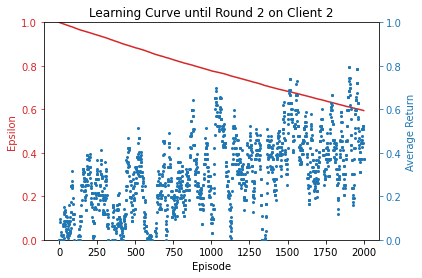

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

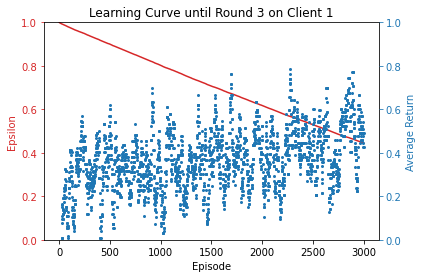

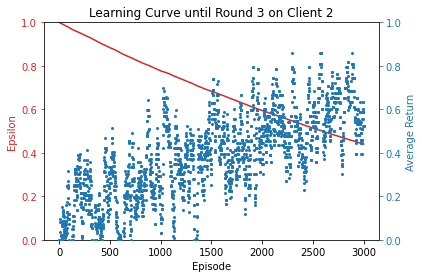

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

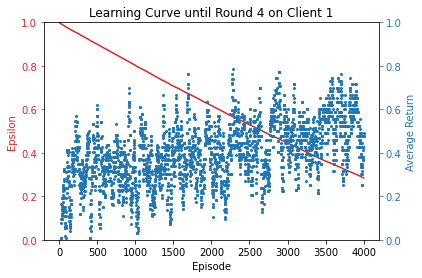

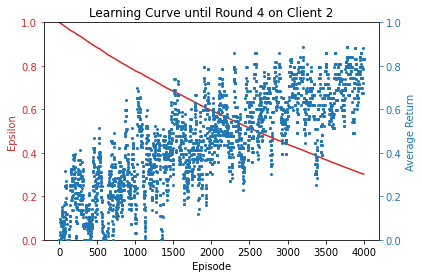

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

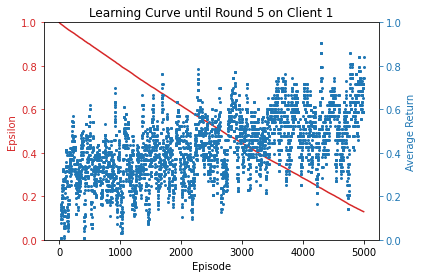

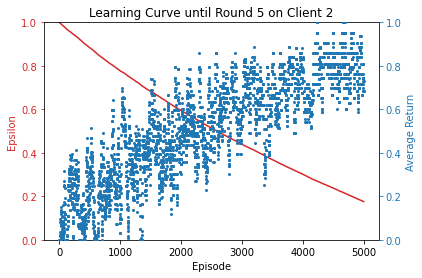

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

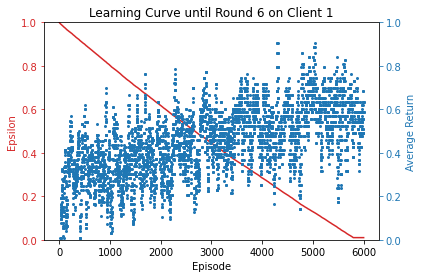

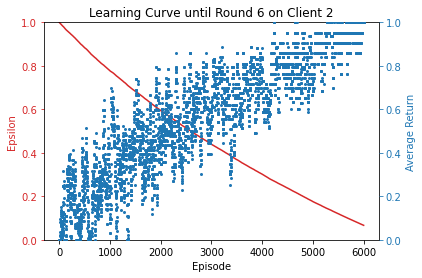

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

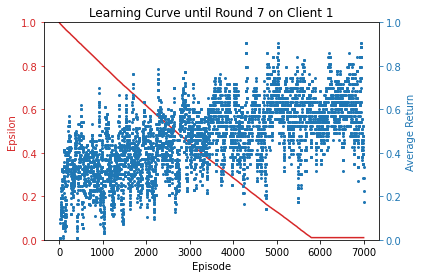

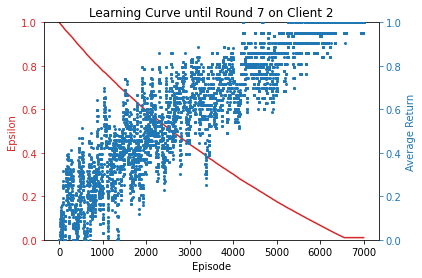

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

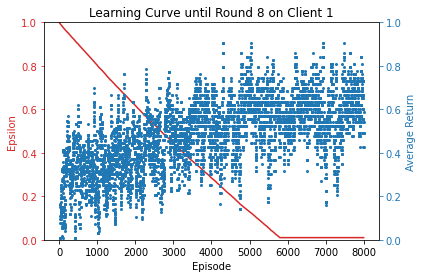

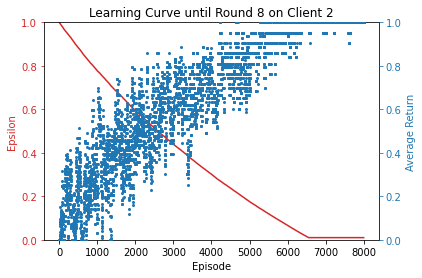

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

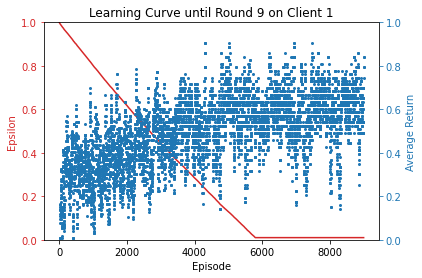

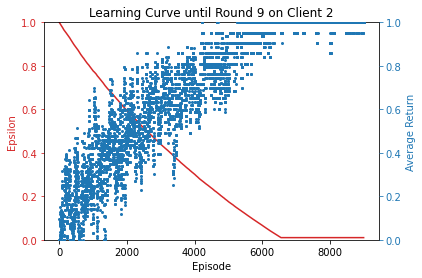

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

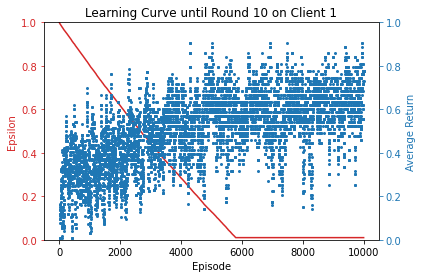

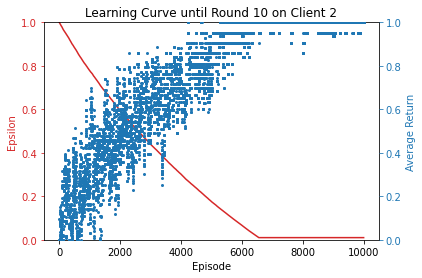

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 100.00%    | rootkit_sanitizer              |
| beurk              | 100.00%    | rootkit_sanitizer              |
| the_tick           | 0.00%      | cnc_ip_shuffle                 |
| backdoor_jakoritar | 0.00%      | cnc_ip_shuffle                 |
| data_leak_1        | 0.00%      | cnc_ip_shuffle                 |
| data_leak_2        | 0.00%      | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 0.00%      | ransomware_file_extension_hide |
| bdvl               | 0.00%      | rootkit_sanitizer              |
| beurk              | 0.00%      | rootkit_sanitizer              |
| the_tick        

In [ ]:
experiment_id = 3
experiment_path = experiments.get_experiment_path(experiment_id)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
NR_ROUNDS = 10


seed_random()

full_train_data, full_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK)
subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1, Behavior.CNC_OPT2)
sub_train_1 = {x: full_train_data[x] for x in subset_1 if x in full_train_data}
sub_train_2 = {x: full_train_data[x] for x in subset_2 if x in full_train_data}

environment_01 = SensorEnvironment(sub_train_1)
environment_02 = SensorEnvironment(sub_train_2)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=True)

client_01 = Client(1, agent_01, environment_01)
client_02 = Client(2, agent_02, environment_02)
# initialize memory replay buffer (randomly)
client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

-----------
#### 4.4 Experiment 04

In [ ]:
experiment_id = 4
experiment_path = experiments.get_experiment_path(experiment_id)

EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
NR_ROUNDS = 10


seed_random()

full_train_data, full_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK)
subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1, Behavior.CNC_OPT2)
sub_train_1 = {x: full_train_data[x] for x in subset_1 if x in full_train_data}
sub_train_2 = {x: full_train_data[x] for x in subset_2 if x in full_train_data}

environment_01 = SensorEnvironment(sub_train_1)
environment_02 = SensorEnvironment(sub_train_2)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path)
client_02 = Client(2, agent_02, environment_02, experiment_path)
# initialize memory replay buffer (randomly)
client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

-----------
#### 4.5 Experiment 05

In [ ]:
experiment_id = 5
experiment_path = experiments.get_experiment_path(experiment_id)

seed_random()

full_train_data, full_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.CNC_OPT1)
subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.ROOTKIT_BEURK , Behavior.CNC_OPT2, Behavior.CNC_BACKDOOR_JAKORITAR)
sub_train_1 = {x: full_train_data[x] for x in subset_1 if x in full_train_data}
sub_train_2 = {x: full_train_data[x] for x in subset_2 if x in full_train_data}

environment_01 = SensorEnvironment(sub_train_1)
environment_02 = SensorEnvironment(sub_train_2)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC, is_global_agent=True)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path)
client_02 = Client(2, agent_02, environment_02, experiment_path)
# initialize memory replay buffer (randomly)
client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

-----------
#### 4.6 Experiment 06

In [ ]:
experiment_id = 6
experiment_path = experiments.get_experiment_path(experiment_id)


seed_random()
start = time()

full_train_data, full_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

subset_1 = (Behavior.NORMAL, Behavior.RANSOMWARE_POC, Behavior.ROOTKIT_BDVL, Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_OPT1)
subset_2 = (Behavior.NORMAL, Behavior.CNC_THETICK, Behavior.ROOTKIT_BEURK , Behavior.CNC_OPT2)
sub_train_1 = {x: full_train_data[x] for x in subset_1 if x in full_train_data}
sub_train_2 = {x: full_train_data[x] for x in subset_2 if x in full_train_data}

environment_01 = SensorEnvironment(sub_train_1)
environment_02 = SensorEnvironment(sub_train_2)


global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC, is_global_agent=True)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)


server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path)
client_02 = Client(2, agent_02, environment_02, experiment_path)
# initialize memory replay buffer (randomly)
client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)


-----------
#### 4.7 Experiment 07

In [ ]:
experiment_id = 7
experiment_path = experiments.get_experiment_path(experiment_id)

NR_ROUNDS = 100
NR_EPISODES_PER_ROUND=100

seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI, normal_only=True)
environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)

# The input size is the number of features 
#print("state size: ", environment_01.observation_space_size)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path)
client_02 = Client(2, agent_02, environment_02, experiment_path)
# initialize memory replay buffer (randomly)
client_01.init_replay_memory(MIN_REPLAY_SIZE)
client_02.init_replay_memory(MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation"])

-----------
#### Experiment 8.1

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01/experiments/experiment_81
/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
>>> SERVER TRAINING ROUND 1/10 <<<
The total training time was 13.549755811691284s
The total training time was 7.499827146530151s
The total training time was 6.957384824752808s
The total training time was 6.4031946659088135s
The total training time was 7.89895224571228s


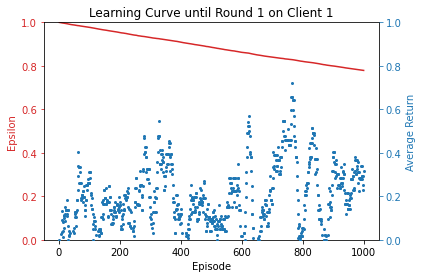

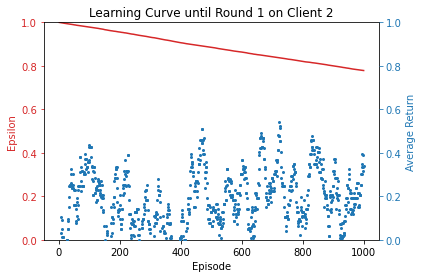

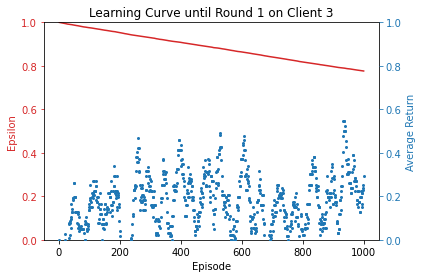

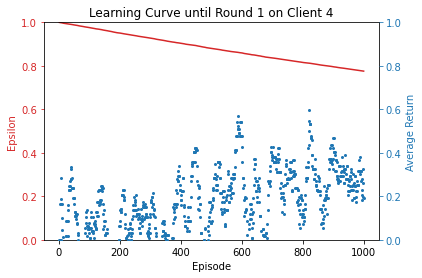

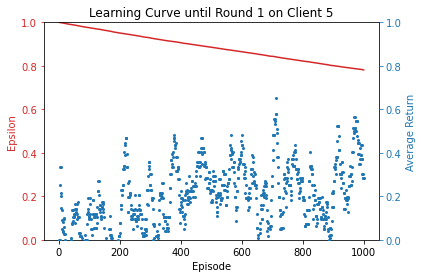

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.07%     | ransomware_file_extension_hide |
| bdvl               | 98.14%     | rootkit_sanitizer              |
| beurk              | 36.69%     | rootkit_sanitizer              |
| the_tick           | 94.06%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 68.08%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.56%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.50%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 43.05%     | rootkit_sanitizer              |
| the_tick        

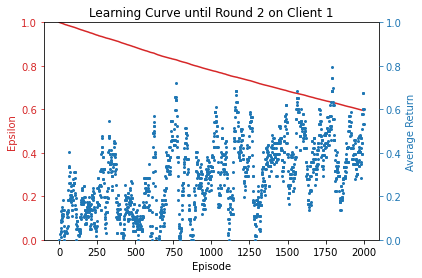

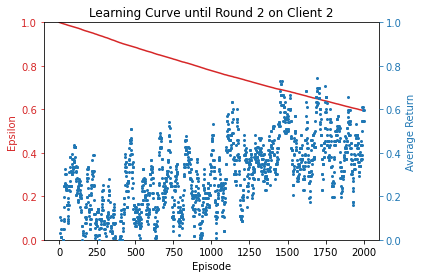

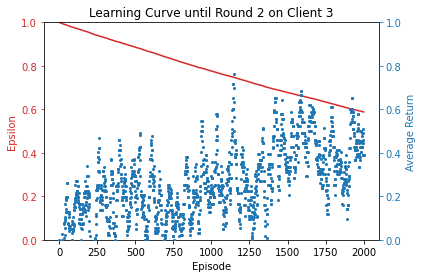

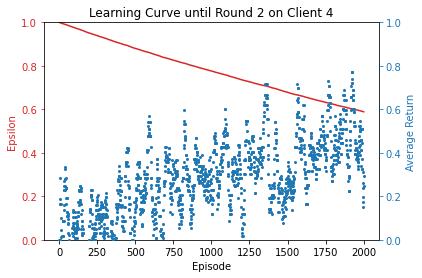

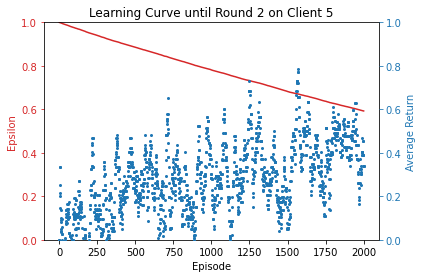

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.45%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 69.61%     | rootkit_sanitizer              |
| the_tick           | 90.73%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 46.36%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.76%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.71%     | ransomware_file_extension_hide |
| bdvl               | 97.52%     | rootkit_sanitizer              |
| beurk              | 51.88%     | rootkit_sanitizer              |
| the_tick        

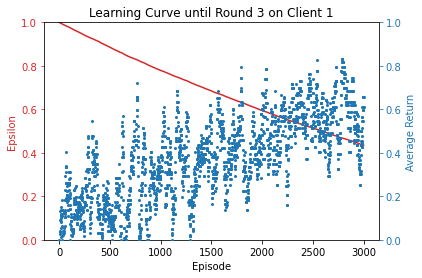

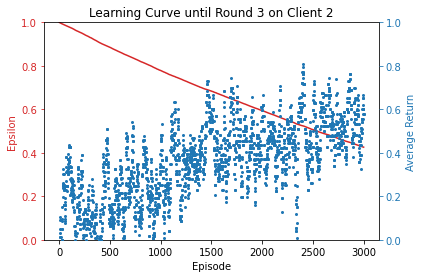

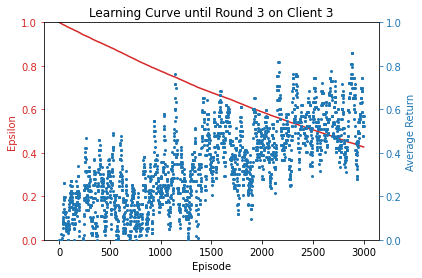

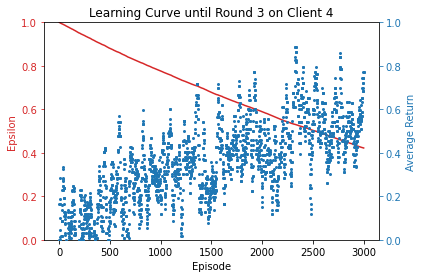

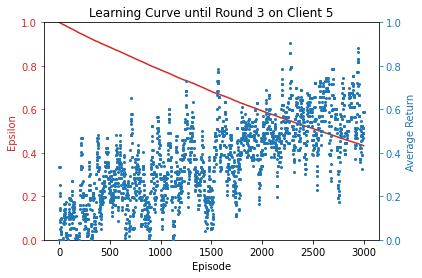

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.45%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 71.12%     | rootkit_sanitizer              |
| the_tick           | 92.36%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 44.60%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.40%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.07%     | ransomware_file_extension_hide |
| bdvl               | 98.49%     | rootkit_sanitizer              |
| beurk              | 69.61%     | rootkit_sanitizer              |
| the_tick        

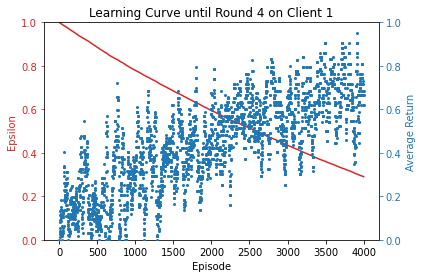

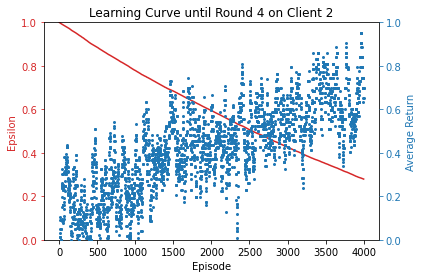

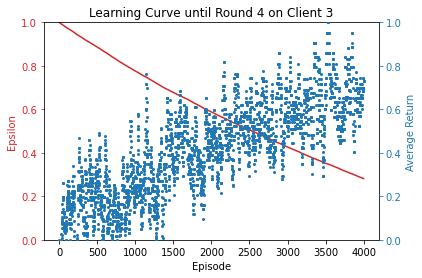

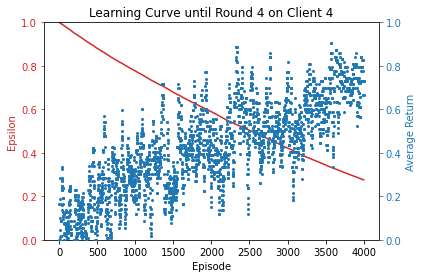

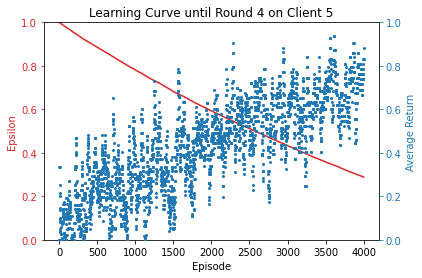

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.85%     | rootkit_sanitizer              |
| beurk              | 74.61%     | rootkit_sanitizer              |
| the_tick           | 94.64%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 40.38%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.67%     | cnc_ip_shuffle                 |
| data_leak_2        | 99.88%     | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.34%     | ransomware_file_extension_hide |
| bdvl               | 99.20%     | rootkit_sanitizer              |
| beurk              | 62.90%     | rootkit_sanitizer              |
| the_tick        

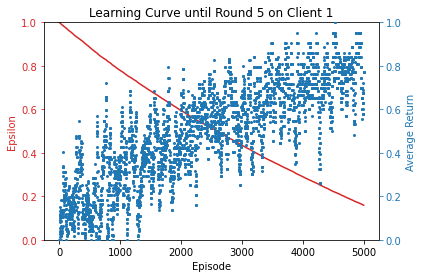

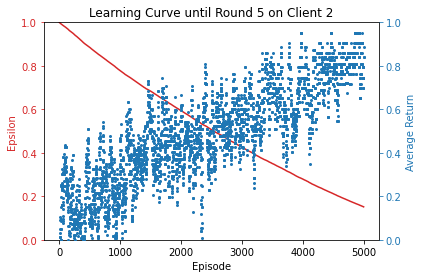

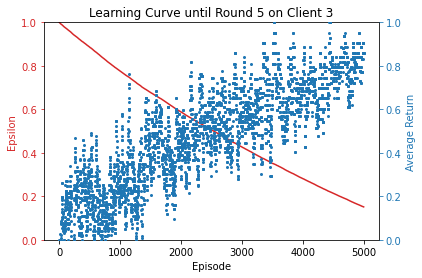

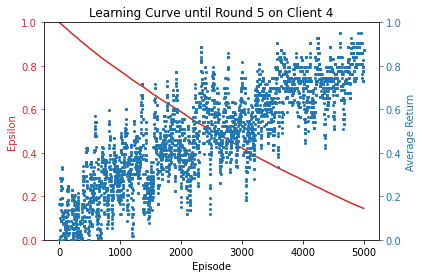

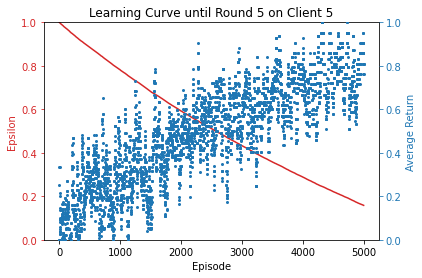

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.55%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 70.57%     | rootkit_sanitizer              |
| the_tick           | 96.93%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 52.82%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.94%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.77%     | ransomware_file_extension_hide |
| bdvl               | 98.14%     | rootkit_sanitizer              |
| beurk              | 67.56%     | rootkit_sanitizer              |
| the_tick        

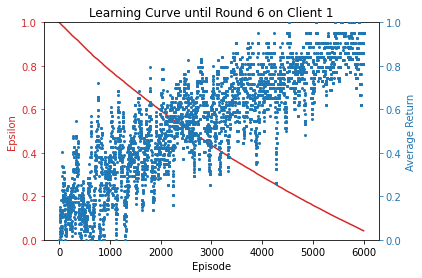

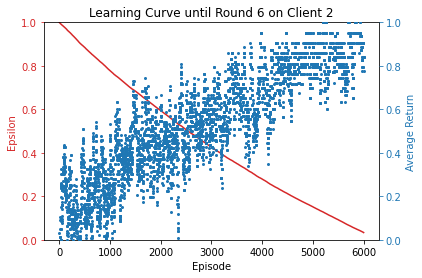

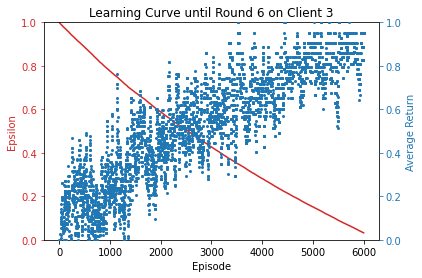

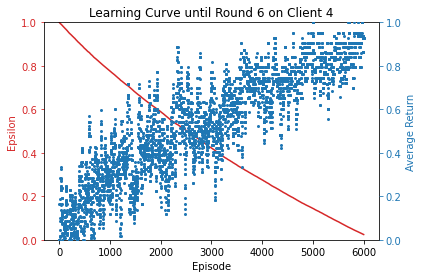

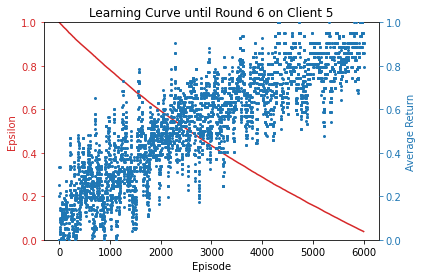

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.55%     | ransomware_file_extension_hide |
| bdvl               | 98.85%     | rootkit_sanitizer              |
| beurk              | 85.69%     | rootkit_sanitizer              |
| the_tick           | 93.47%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 30.63%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.85%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.94%     | rootkit_sanitizer              |
| beurk              | 67.62%     | rootkit_sanitizer              |
| the_tick        

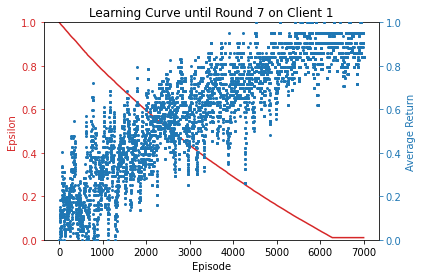

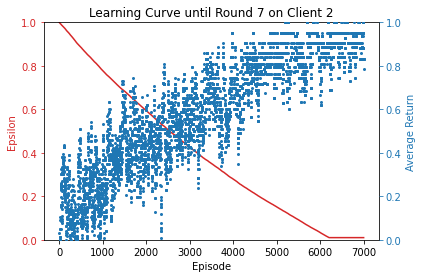

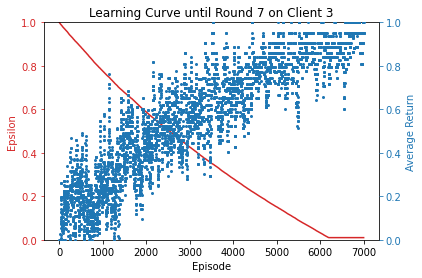

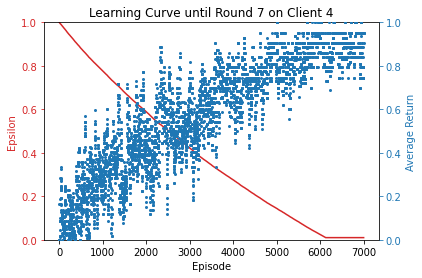

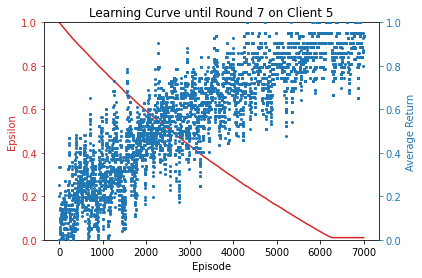

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 99.04%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 73.92%     | rootkit_sanitizer              |
| the_tick           | 96.86%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 57.04%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.56%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.71%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 79.47%     | rootkit_sanitizer              |
| the_tick        

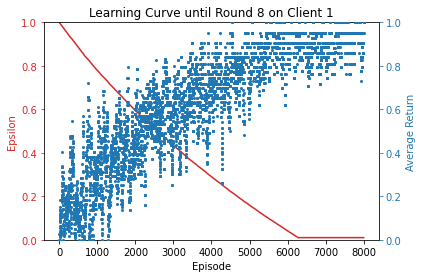

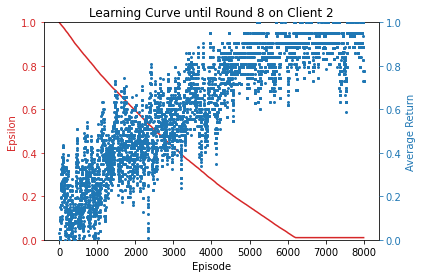

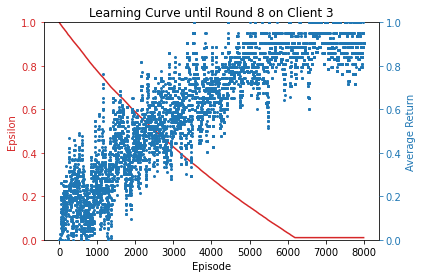

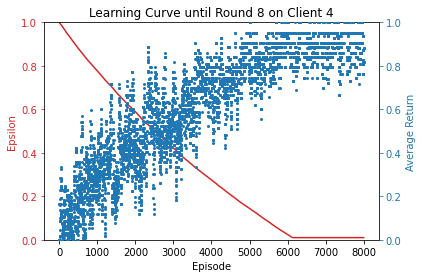

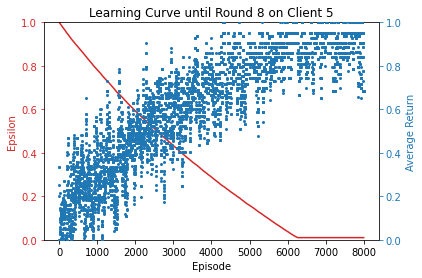

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.12%     | ransomware_file_extension_hide |
| bdvl               | 98.85%     | rootkit_sanitizer              |
| beurk              | 85.08%     | rootkit_sanitizer              |
| the_tick           | 93.60%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 42.84%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.11%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.94%     | rootkit_sanitizer              |
| beurk              | 46.82%     | rootkit_sanitizer              |
| the_tick        

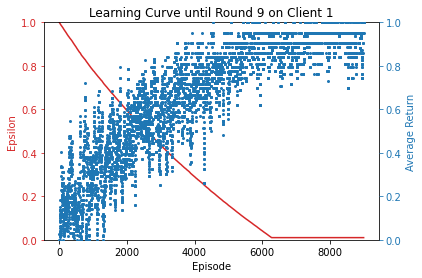

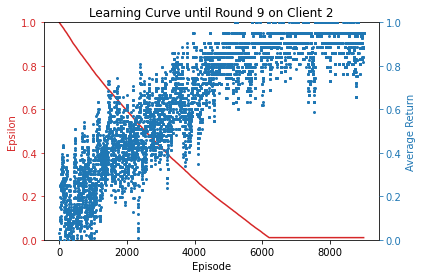

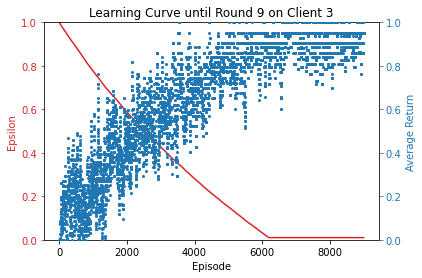

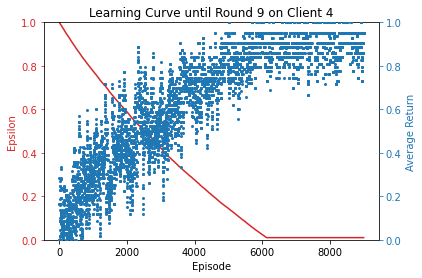

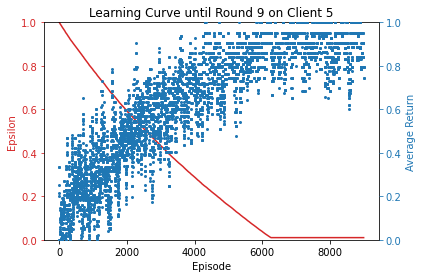

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.77%     | ransomware_file_extension_hide |
| bdvl               | 98.58%     | rootkit_sanitizer              |
| beurk              | 86.11%     | rootkit_sanitizer              |
| the_tick           | 93.86%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 27.35%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.38%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.82%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 59.82%     | rootkit_sanitizer              |
| the_tick        

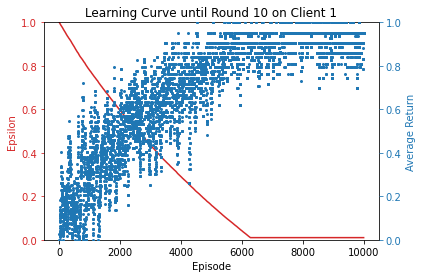

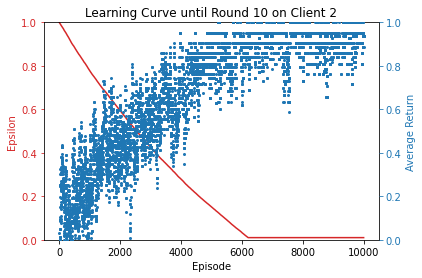

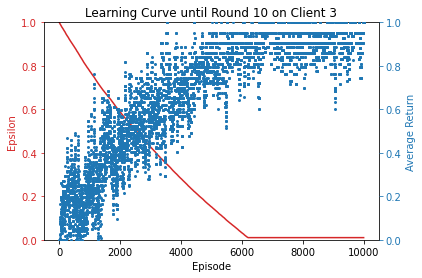

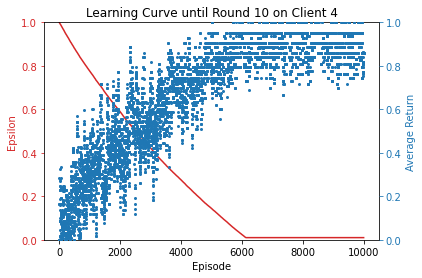

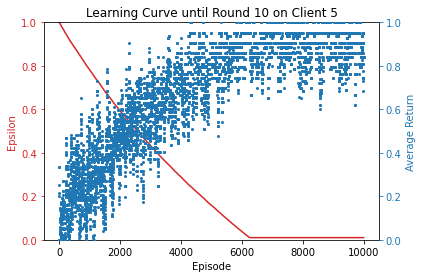

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 99.38%     | rootkit_sanitizer              |
| beurk              | 82.14%     | rootkit_sanitizer              |
| the_tick           | 95.30%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 42.96%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.38%     | cnc_ip_shuffle                 |
| data_leak_2        | 99.03%     | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 58.18%     | rootkit_sanitizer              |
| the_tick        

In [108]:
experiment_id = 81
experiment_path = experiments.get_experiment_path(experiment_id)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI, normal_only=True)
environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)



for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    server.add_client(client)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01/experiments/experiment_82
/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
>>> SERVER TRAINING ROUND 1/10 <<<
The total training time was 11.23046088218689s
The total training time was 11.723161220550537s
The total training time was 12.657185077667236s
The total training time was 15.311684131622314s
The total training time was 10.823932886123657s


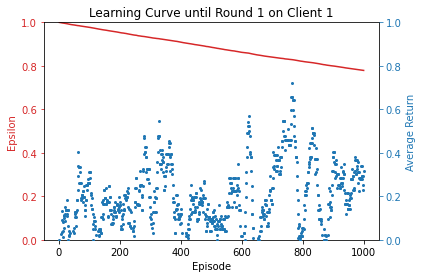

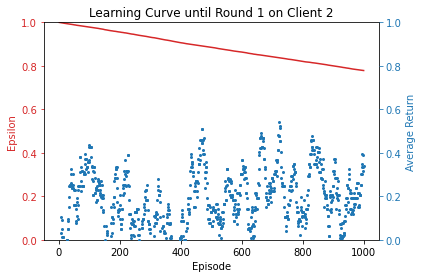

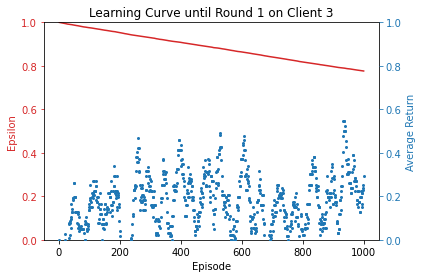

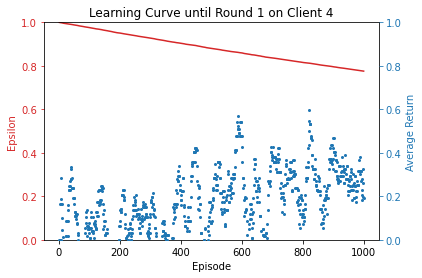

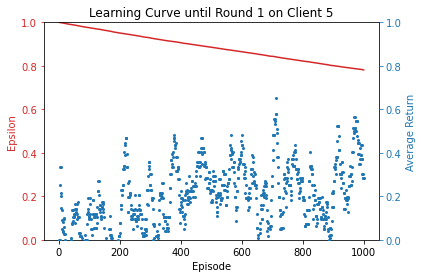

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.07%     | ransomware_file_extension_hide |
| bdvl               | 98.14%     | rootkit_sanitizer              |
| beurk              | 36.69%     | rootkit_sanitizer              |
| the_tick           | 94.06%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 68.08%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.56%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.50%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 43.05%     | rootkit_sanitizer              |
| the_tick        

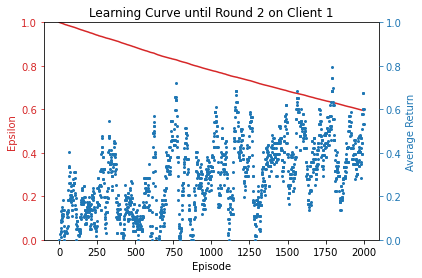

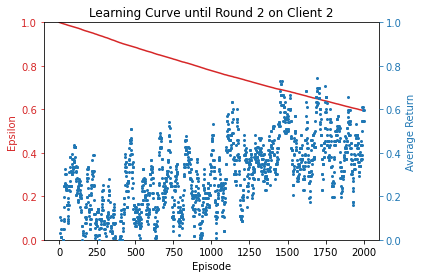

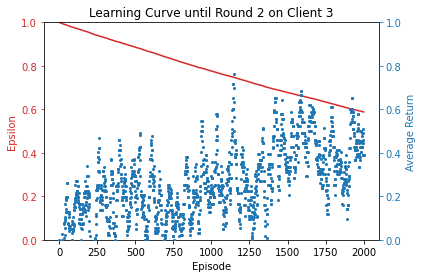

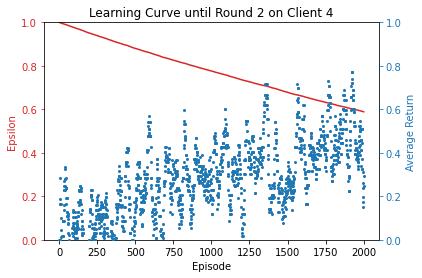

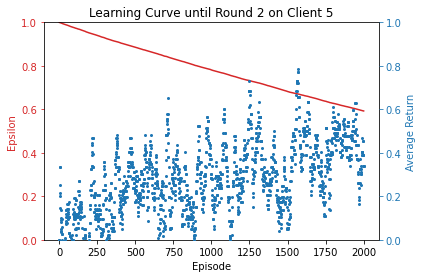

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.45%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 69.61%     | rootkit_sanitizer              |
| the_tick           | 90.73%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 46.36%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.76%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.71%     | ransomware_file_extension_hide |
| bdvl               | 97.52%     | rootkit_sanitizer              |
| beurk              | 51.88%     | rootkit_sanitizer              |
| the_tick        

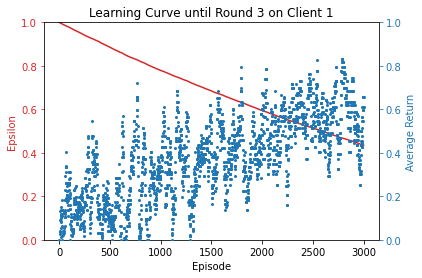

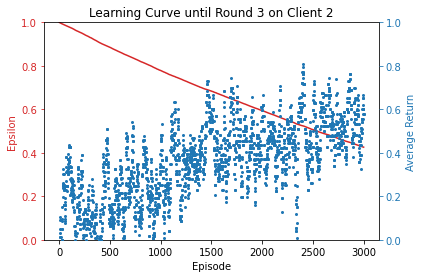

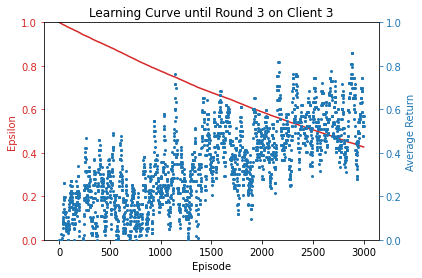

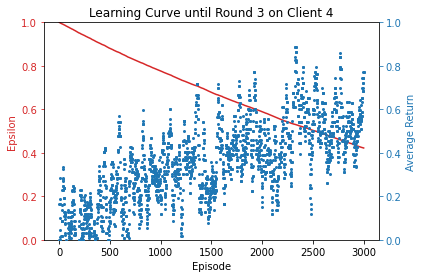

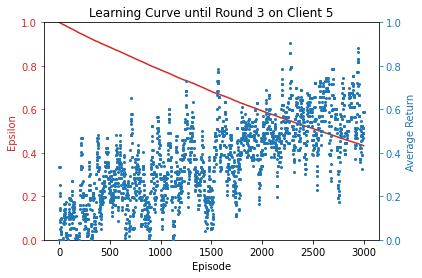

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.45%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 71.12%     | rootkit_sanitizer              |
| the_tick           | 92.36%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 44.60%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.40%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.07%     | ransomware_file_extension_hide |
| bdvl               | 98.49%     | rootkit_sanitizer              |
| beurk              | 69.61%     | rootkit_sanitizer              |
| the_tick        

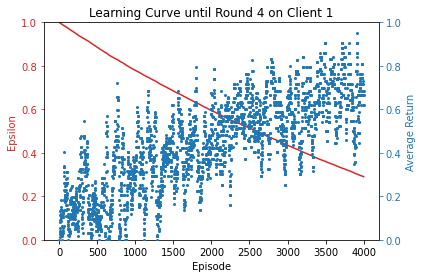

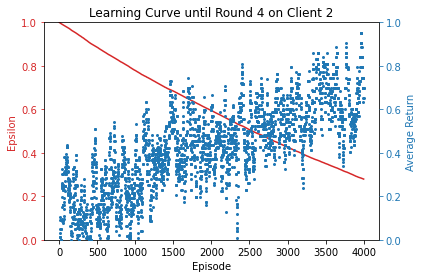

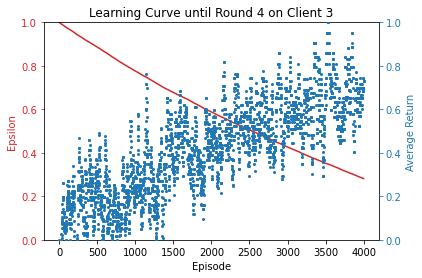

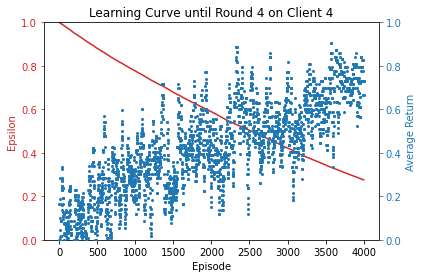

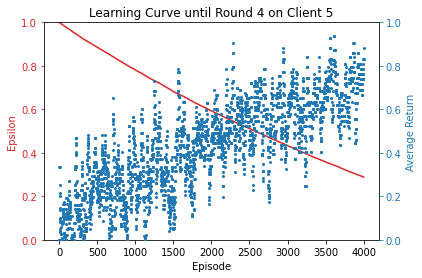

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.85%     | rootkit_sanitizer              |
| beurk              | 74.61%     | rootkit_sanitizer              |
| the_tick           | 94.64%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 40.38%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.67%     | cnc_ip_shuffle                 |
| data_leak_2        | 99.88%     | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.34%     | ransomware_file_extension_hide |
| bdvl               | 99.20%     | rootkit_sanitizer              |
| beurk              | 62.90%     | rootkit_sanitizer              |
| the_tick        

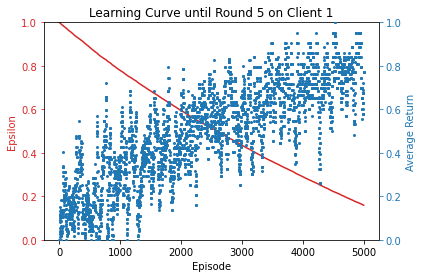

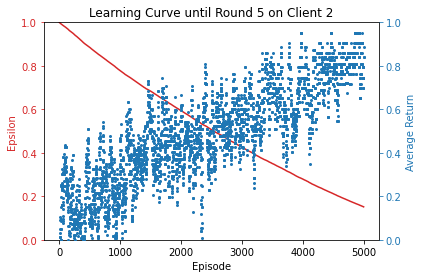

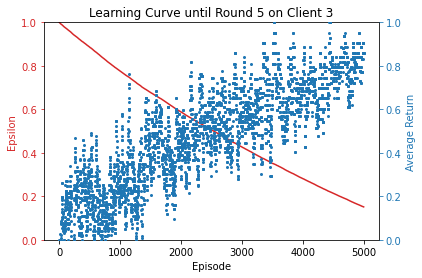

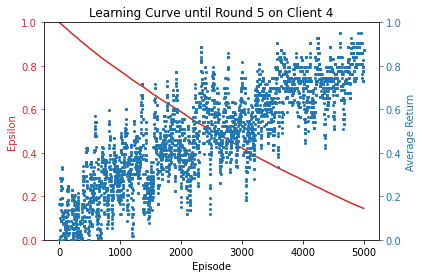

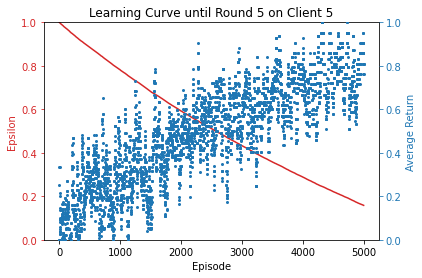

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.55%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 70.57%     | rootkit_sanitizer              |
| the_tick           | 96.93%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 52.82%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.94%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.77%     | ransomware_file_extension_hide |
| bdvl               | 98.14%     | rootkit_sanitizer              |
| beurk              | 67.56%     | rootkit_sanitizer              |
| the_tick        

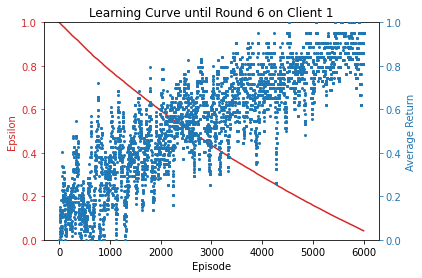

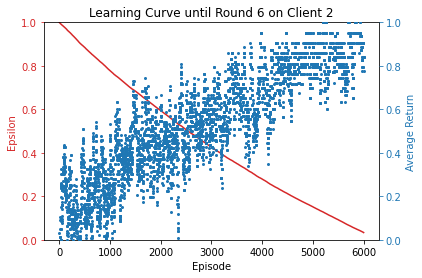

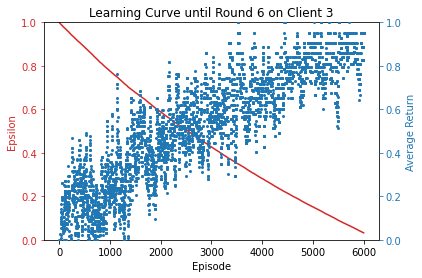

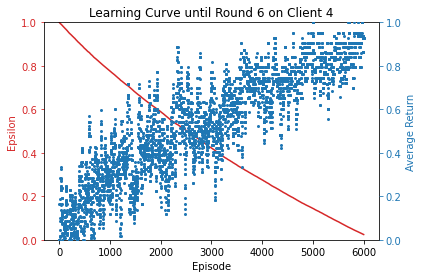

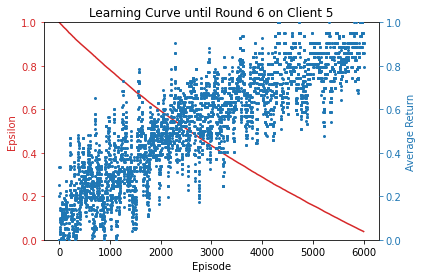

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.55%     | ransomware_file_extension_hide |
| bdvl               | 98.85%     | rootkit_sanitizer              |
| beurk              | 85.69%     | rootkit_sanitizer              |
| the_tick           | 93.47%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 30.63%     | cnc_ip_shuffle                 |
| data_leak_1        | 98.85%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.94%     | rootkit_sanitizer              |
| beurk              | 67.62%     | rootkit_sanitizer              |
| the_tick        

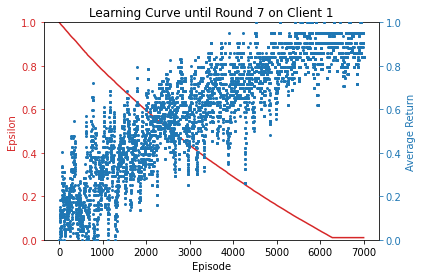

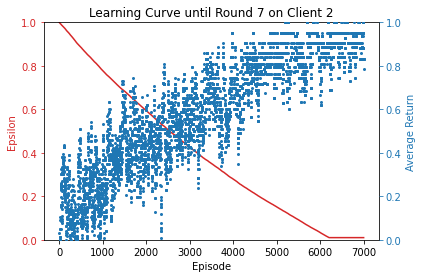

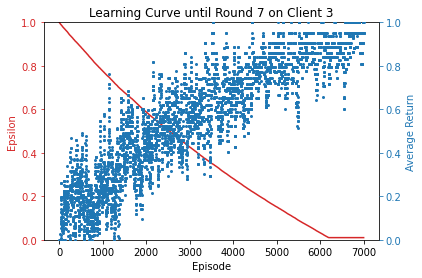

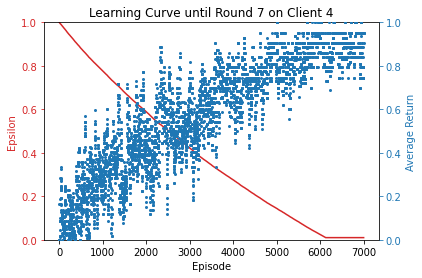

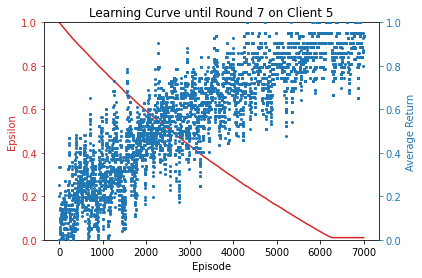

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 99.04%     | ransomware_file_extension_hide |
| bdvl               | 98.67%     | rootkit_sanitizer              |
| beurk              | 73.92%     | rootkit_sanitizer              |
| the_tick           | 96.86%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 57.04%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.56%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.71%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 79.47%     | rootkit_sanitizer              |
| the_tick        

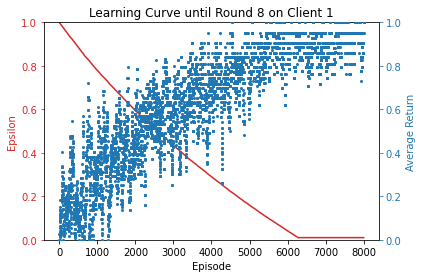

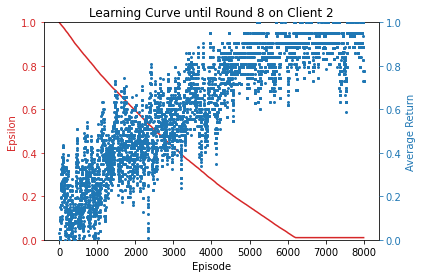

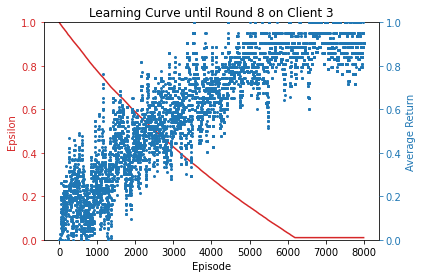

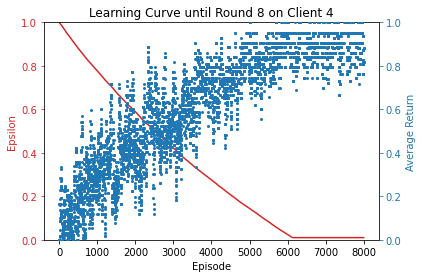

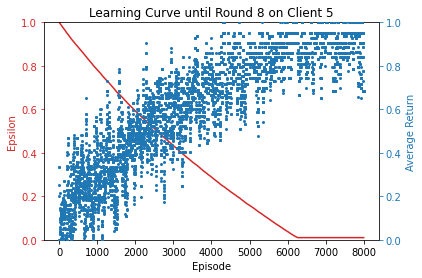

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.12%     | ransomware_file_extension_hide |
| bdvl               | 98.85%     | rootkit_sanitizer              |
| beurk              | 85.08%     | rootkit_sanitizer              |
| the_tick           | 93.60%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 42.84%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.11%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.94%     | rootkit_sanitizer              |
| beurk              | 46.82%     | rootkit_sanitizer              |
| the_tick        

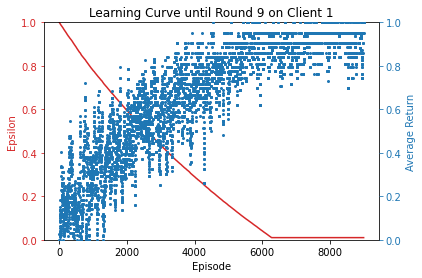

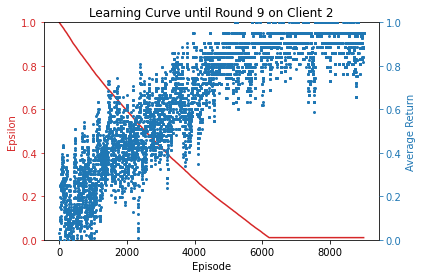

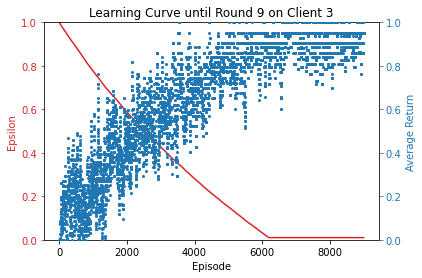

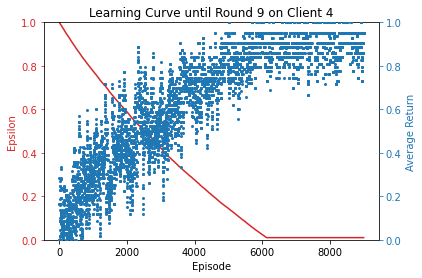

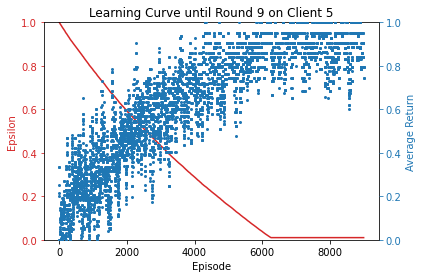

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.77%     | ransomware_file_extension_hide |
| bdvl               | 98.58%     | rootkit_sanitizer              |
| beurk              | 86.11%     | rootkit_sanitizer              |
| the_tick           | 93.86%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 27.35%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.38%     | cnc_ip_shuffle                 |
| data_leak_2        | 100.00%    | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.82%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 59.82%     | rootkit_sanitizer              |
| the_tick        

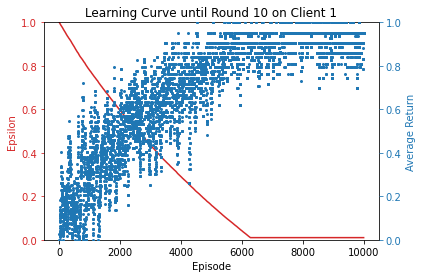

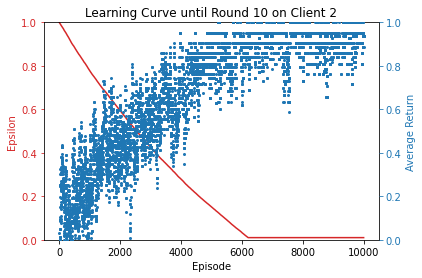

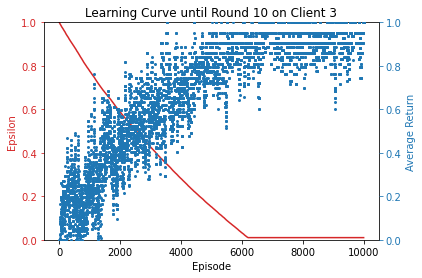

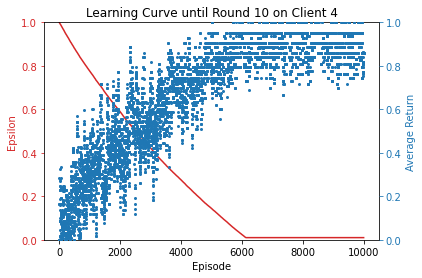

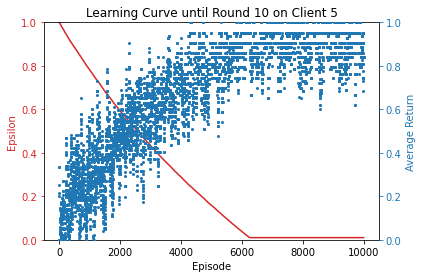

Agent 1
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 99.38%     | rootkit_sanitizer              |
| beurk              | 82.14%     | rootkit_sanitizer              |
| the_tick           | 95.30%     | cnc_ip_shuffle                 |
| backdoor_jakoritar | 42.96%     | cnc_ip_shuffle                 |
| data_leak_1        | 99.38%     | cnc_ip_shuffle                 |
| data_leak_2        | 99.03%     | cnc_ip_shuffle                 |
Agent 2
| Behavior           | Accuracy   | Objective                      |
|:-------------------|:-----------|:-------------------------------|
| ransomware_poc     | 98.61%     | ransomware_file_extension_hide |
| bdvl               | 98.76%     | rootkit_sanitizer              |
| beurk              | 58.18%     | rootkit_sanitizer              |
| the_tick        

In [109]:
experiment_id = 82
experiment_path = experiments.get_experiment_path(experiment_id)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI, normal_only=True)
environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=True)



for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    server.add_client(client)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)

-----------
#### 4.9 Experiment 09

In [ ]:
experiment_id = 9
experiment_path = experiments.get_experiment_path(experiment_id)

NR_ROUNDS = 100
NR_EPISODES_PER_ROUND=100
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI, normal_only=True)
environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, full_test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)



for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    server.add_client(client)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=10)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01/experiments/experiment_10
/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
NORMAL
ROOTKIT_BDVL
ROOTKIT_BEURK
CNC_BACKDOOR_JAKORITAR
CNC_THETICK
CNC_OPT1
CNC_OPT2
RANSOMWARE_POC


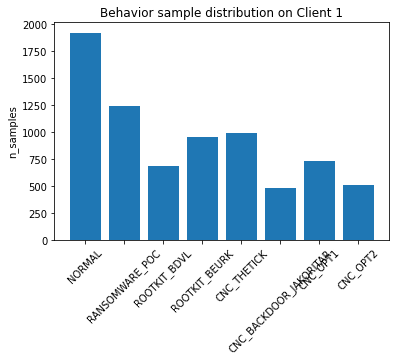

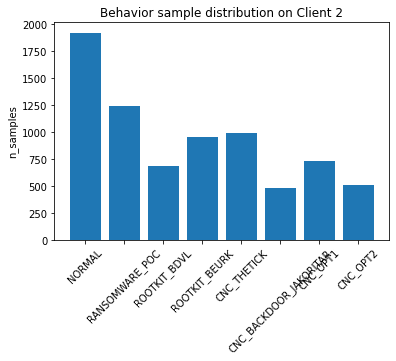

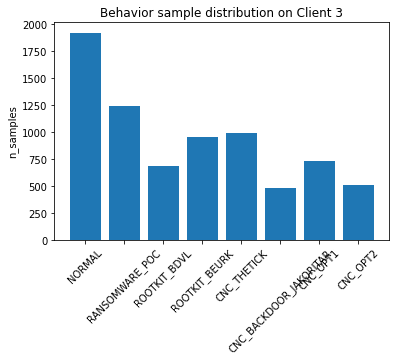

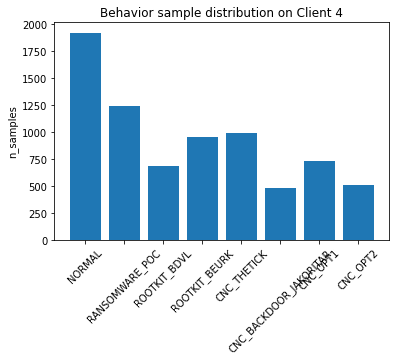

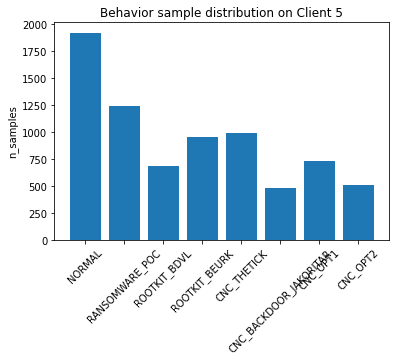

In [41]:
experiments = Experiment(original_working_directory_path)
experiment_id = 10
experiment_path = experiments.get_experiment_path(experiment_id)

NR_ROUNDS = 100
NR_EPISODES_PER_ROUND=100
NR_CLIENTS = 5

environemnts = []
clients = []

seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
training_data_strides = split_training_data(train_data, NR_CLIENTS)

# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI, normal_only=True)
environment = SensorEnvironment(train_data)
global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

for behavior in Behavior:
    print(str(behavior).split('.')[1])

for i in range(NR_CLIENTS):
    id = i + 1
    environment = SensorEnvironment(training_data_strides[i])
    agent = Agent(id, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(id, agent, environment, experiment_path)
    client.init_replay_memory(MIN_REPLAY_SIZE)
    client.plot_training_data_split()
    server.add_client(client)

#server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=10)